In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from sqlalchemy import create_engine
from scipy.stats import bartlett, jarque_bera, levene, normaltest

import warnings
warnings.filterwarnings('ignore')


postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


In [3]:
weather.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


We have our dataframe ready. Since we also know our features let's begin by building a model:

In [4]:
Y = weather['temperature']
X = weather[['humidity','windspeed','windbearing','pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528538


In [5]:
results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            temperature   R-squared (uncentered):                   0.712
Model:                            OLS   Adj. R-squared (uncentered):              0.712
Method:                 Least Squares   F-statistic:                          5.950e+04
Date:                Tue, 21 Jul 2020   Prob (F-statistic):                        0.00
Time:                        02:42:17   Log-Likelihood:                     -3.3991e+05
No. Observations:               96453   AIC:                                  6.798e+05
Df Residuals:                   96449   BIC:                                  6.799e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
humidity      -23.9965      0.126   -190.964      0.000     -24.243     -23.750
windspeed      -0.0460      0.004    -12.103      0.000      -0.053      -0.039
windbearing     0.0096      0.000     39.178      0.000       0.009       0.010
pressure        0.0278      0.000    252.540      0.000       0.028       0.028
==============================================================================
Omnibus:                     3331.234   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7796.776
Skew:                           0.191   Prob(JB):                         0.00
Kurtosis:                       4.339   Cond. No.                     4.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##**Gauss-Markov assumptions:**

#1. Linearity of model in its coefficients:

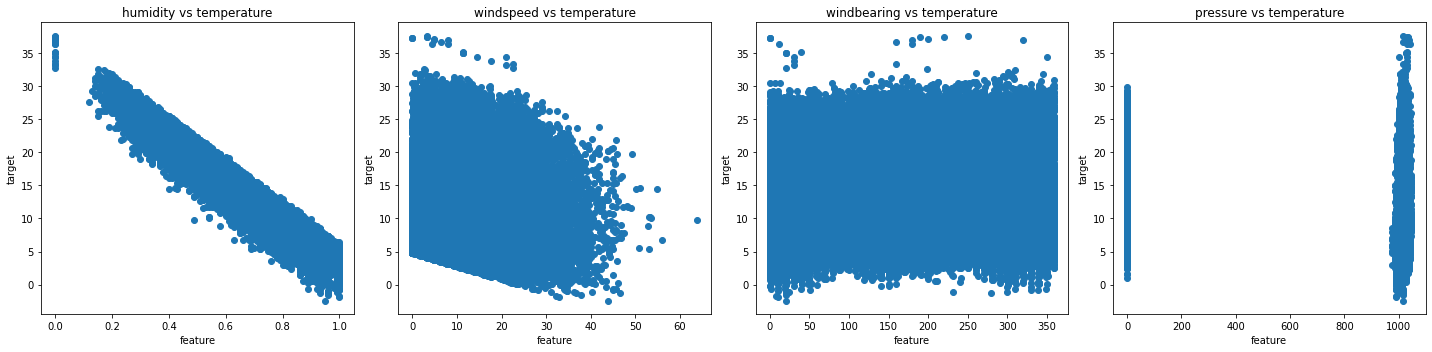

In [6]:
# predictions of the linear regression
predictions = lrm.predict(X)

# we plot the estimated Y and X
# the relationship should be quadratic

plt.figure(figsize=(20, 5))
i = 0
for column in X.columns:
    i +=1
    plt.tight_layout()
    plt.subplot(1, 4, i)
    plt.scatter(weather[column], predictions)
    plt.xlabel("feature")
    plt.ylabel("target")
    plt.title('{} vs temperature'.format(column))
plt.show()



The first plot shows that humidity has a negative linear relationship with temperature, manifesting in a declining trend.

The second plot does show some linearity that leans toward the negative side, but since windspeed is not necessarily a phenomenon that relates to temperature, its linearity has its limits, e.g high wind speeds can occurr in hurricanes that occur during warmer periods.

The last two plots show no linearity, windbearing is scattered all over the plot and looks more like noise than it is a relationship, and pressure shows two possible values (or narrow ranges of values) that have no visible relationship with temperature.

#2. The error term should be zero on average

In [7]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of errors: {}".format(np.mean(errors)))

Mean of errors: -3.732130268532674e-15


We will be adding a constant to the model so that the average errors becomes zero.

#3. Homoscedasticity

Let's checkout whether our model suffers from heteroscedasticity by visualizing and Statistical tests:

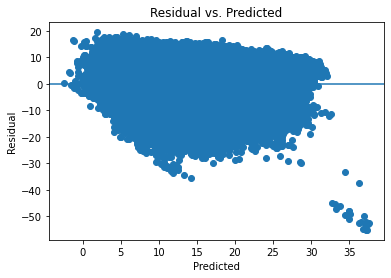

In [8]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Let's use **Bartlett** and **Levene** tests. The null hypothesis for both tests is that the errors are homoscedastic.

Let's use these tests to find out whether our error are homoscedastic or not:

In [9]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {} and p value is {}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {} and p value is {}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.844656867369 and p value is 0.0
Levene test statistic value is 2321.2401008574006 and p value is 0.0


The p-values of both tests are 0. Which means our errors are not homoscedastic..

#4. Low multicollinearity

To check for multicollinearity, let's take a look at correlation of features:

In [10]:
X.corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224951,0.000735,0.005454
windspeed,-0.224951,1.000000,0.103822,-0.049263
windbearing,0.000735,0.103822,1.000000,-0.011651
pressure,0.005454,-0.049263,-0.011651,1.000000


Our features have low multicollinearity. This matches the fourth assumption.

#5. Error terms should be uncorrelated with one another

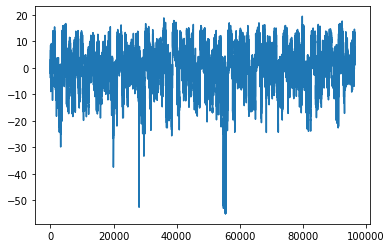

In [11]:
plt.plot(errors)
plt.show()

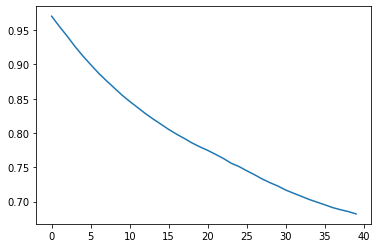

In [12]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Model errors seem to be correlated, which is against the fifth assumption.

#6. Features shouldn't be correlated with the errors

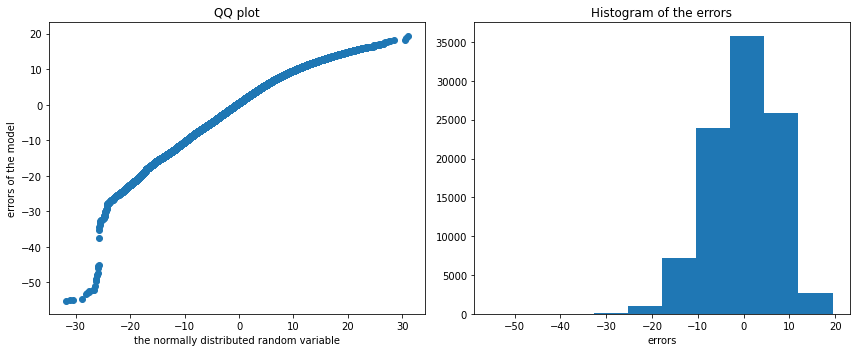

In [13]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In the charts above, our errors are not normally distributed exactly. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

Let's use **Jarque Bera** and **normal tests**. The null hypothesis of both tests is that the errors are normally distributed.

Let's use these tests to find out whether our error terms are normally distributed or not:

In [14]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252357 and p value is 0.0
Normality test statistics is 3375.4323076995743 and p value is 0.0


The p-values of both tests indicate that our errors are not normally distributed.